In [24]:
import os, glob
import pandas as pd

from matplotlib import pyplot as plt 
import numpy as np  
from numpy import reshape  

from random import sample
import random

# P_17 - Marjoland Teeltgewicht

This code is about predicting the weight of roses. The code relates the results of measurements of the dimensions of roses with the Aweta harvest machine with a manual measurement for the weight of roses and thus becomes able to predict the weight of roses with the measurement from only the Aweta harvest machine.

The code is implemented in the Google Cloud to the prediction on a daily basis. 


## Meetdata

With a manual weight scale, the weight of roses was measured.  With a marker, a unique number was written on the rose for registration.  The test was repeated on different days. 

![manual measurement of the roses](C:\Users\602956\Downloads\Roosweging.JPG)


In [19]:
all_files = glob.glob('D:\P_17 - roosgewicht\data' + "/*.csv")

test_files = (pd.read_csv(f, sep=';',decimal='.') for f in all_files)

roosgewicht   = pd.concat(test_files, ignore_index=True)
roosgewicht.to_csv( "merged.csv")
roosgewicht = roosgewicht[["sessie", "lot id", "gr"]]
roosgewicht = roosgewicht.rename(columns={"lot id": "lot_id"})

# gewicht
roosgewicht.gr = roosgewicht.gr.str.replace(',','.')
roosgewicht.gr = pd.to_numeric(roosgewicht["gr"])

# lot_id
roosgewicht = roosgewicht[roosgewicht.lot_id !=999]
roosgewicht = roosgewicht[roosgewicht.lot_id.notnull()]
roosgewicht.lot_id = roosgewicht.lot_id.astype(int)

roosgewicht.head().style.set_caption('table with results of measurement. gr is the result in gramms.')



,sessie,lot_id,gr
0,1,53,36.400000
1,1,10,38.700000
2,1,54,55.400000
3,1,56,56.400000
4,1,58,33.300000


### Test for normality

If p < 0.05 the data is not normal distributed. 

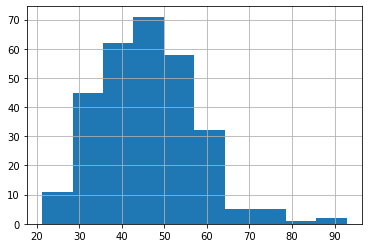

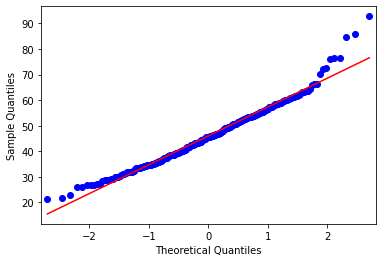

Statistics=0.975, p=0.00006


In [25]:
from scipy.stats import shapiro#, norm
import statsmodels.api as sm
import pylab

roosgewicht.gr.hist()

sm.qqplot(roosgewicht.gr, line='s')
pylab.show()

stat, p = shapiro(roosgewicht.gr)
print('Statistics=%.3f, p=%.5f' % (stat, p))

## Aweta harvest machine data

Data from the harvesting machine was extracted. After the measurement, the roses were rotated in the machine and measured again.

From the machine, we used the followig translation of parameters:

* lot.id = 4
* Steellengte = 140
* knopbreedte = 114
* knophoogte = 113
* knoprijpheid = 118
* knopkleur = 117
* steeldikte = 141
* kromming = 37
* Codeerbaan = 109


In [20]:
from collections import OrderedDict
import xmltodict

all_xml_files = glob.glob('D:\P_17 - roosgewicht\data' + "/*.xml")

def read_row(row):
    params = []
            
    for params_dict in file[row]['parameters']['parameter']:
        params_new_naming = {key[1:]: value for key, value in params_dict.items()}
        params.append(params_new_naming)

    df = pd.DataFrame(params)[['id', 'text']]
    df = df[df.id.isin(['4', '140', '141', '114', '113'])]

    df = df.set_index('id').transpose().rename(columns={"4": "lot_id"})
     
    return(df) 

appended_data = []
    
    
for file_path in all_xml_files:
    
    sessie = file_path[27:100].split(" ")[0].replace('sesie_', '')
    machine = file_path[27:100].split(" ")[2].split(".")[0].replace('machine_', '')
    
    file = open(file_path, mode="rb")
    blob_content = file.read()

    file= xmltodict.parse(blob_content)
    file = file['producthistory']['products']['product']
    
    test_files = (read_row(r) for r in range(0, len(file)))
    df = pd.concat(test_files, ignore_index=True)
    df['sessie'], df['machine'] = sessie, machine
    
    df.lot_id = df.lot_id.astype(int)
    df.sessie = df.sessie.astype(int)
    
    appended_data.append(df)
    
    
aweta_data = pd.concat(appended_data)
aweta_data = aweta_data[aweta_data['113'].notnull()]
aweta_data = aweta_data[aweta_data['140'].notnull()]

for i in [i for i in list(range(len(aweta_data.columns))) if i not in ['id', 'lot_id','sessie', 'machine']]:
    aweta_data.iloc[:,i]=pd.to_numeric(aweta_data.iloc[:,i])

aweta_data.head().style.set_caption('the result from the Aweta machine, with the relevant parametes from the machiene.')


id,lot_id,113,114,140,141,sessie,machine
0,1,483,469,613,58,1,1
1,2,452,408,652,58,1,1
2,3,499,435,595,56,1,1
3,4,655,548,695,98,1,1
4,5,530,565,674,55,1,1


# Model

SVR is used to make the prediction.


In [21]:
from sklearn import linear_model
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


In [22]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')


   sessie  lot_id    gr  113  114  140  141  machine
1       1      53  36.4  501  539  613   60        1
2       1      53  36.4  515  539  612   58        1

aantal rijen train data: 1135
aantal rijen test data: 114


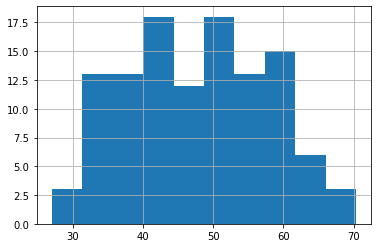

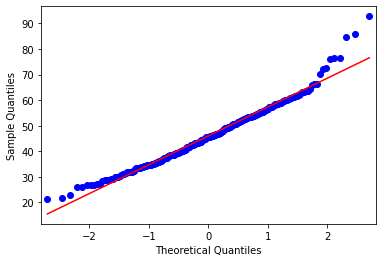

Statistics=0.975, p=0.00006


In [42]:
random.seed(11)

data = pd.merge(roosgewicht,aweta_data,on=['lot_id','sessie'],how='left')
test_id = sample(set(data.lot_id),10)

train_t = data[~data.lot_id.isin( test_id ) ].drop(['sessie', 'lot_id', 'machine', 'gr'], axis=1)
train_l = data[~data.lot_id.isin( test_id ) ].gr

test_t = data[data.lot_id.isin( test_id ) ].drop(['sessie', 'lot_id', 'machine', 'gr'], axis=1)
test_l = data[data.lot_id.isin( test_id ) ].gr

print()
print(data[1:3])
print()
print( "aantal rijen train data: "+ str( len(train_t)) )
print( "aantal rijen test data: " + str( len(test_t)) ) 

test_l.hist()

sm.qqplot(roosgewicht.gr, line='s')
pylab.show()

stat, p = shapiro(roosgewicht.gr)
print('Statistics=%.3f, p=%.5f' % (stat, p))

In [43]:
%%time
  
gg = 10.0 ** np.arange(-6, -3)
cc = [1,10, 100]
ee = [.1, 0.5, 1] #, 'epsilon': ee
tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': gg,'C':cc, 'epsilon': ee },
    {'kernel': ['poly'], 'gamma': gg, 'C': cc, 'epsilon': ee, 'degree': [ 2, 3, 4] },
    {'kernel': ['linear'], 'C': cc, 'epsilon': ee }
    ]

svr = GridSearchCV(SVR( ), tuned_parameters, cv = 5, n_jobs = -1 )

svr.fit(train_t, train_l)

Wall time: 1h 46s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100], 'epsilon': [0.1, 0.5, 1],
                          'gamma': array([1.e-06, 1.e-05, 1.e-04]),
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100], 'degree': [2, 3, 4],
                          'epsilon': [0.1, 0.5, 1],
                          'gamma': array([1.e-06, 1.e-05, 1.e-04]),
                          'kernel': ['poly']},
                         {'C': [1, 10, 100], 'epsilon': [0.1, 0.5, 1],
                          'kernel': ['linear']}])

In [44]:
print(svr.best_params_)

means = svr.cv_results_['mean_test_score']
stds = svr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svr.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

{'C': 1, 'degree': 4, 'epsilon': 1, 'gamma': 1e-05, 'kernel': 'poly'}
0.328 (+/-0.214) for {'C': 1, 'epsilon': 0.1, 'gamma': 1e-06, 'kernel': 'rbf'}
0.535 (+/-0.160) for {'C': 1, 'epsilon': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.516 (+/-0.161) for {'C': 1, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.326 (+/-0.212) for {'C': 1, 'epsilon': 0.5, 'gamma': 1e-06, 'kernel': 'rbf'}
0.534 (+/-0.159) for {'C': 1, 'epsilon': 0.5, 'gamma': 1e-05, 'kernel': 'rbf'}
0.520 (+/-0.153) for {'C': 1, 'epsilon': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}
0.324 (+/-0.208) for {'C': 1, 'epsilon': 1, 'gamma': 1e-06, 'kernel': 'rbf'}
0.532 (+/-0.157) for {'C': 1, 'epsilon': 1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.520 (+/-0.161) for {'C': 1, 'epsilon': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.553 (+/-0.156) for {'C': 10, 'epsilon': 0.1, 'gamma': 1e-06, 'kernel': 'rbf'}
0.655 (+/-0.181) for {'C': 10, 'epsilon': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.645 (+/-0.225) for {'C': 10, 'epsilon': 0.1, 'gamma': 0.0001

'poly' is de beste methode, Gamma 1e-5. For C and degree, we do another computation.

{'C': 10, 'degree': 3}
Wall time: 1min 8s


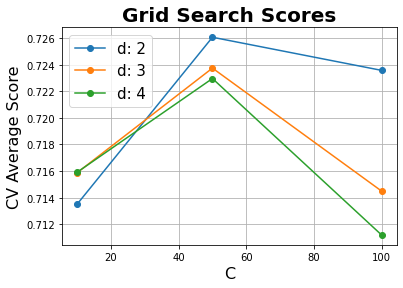

In [45]:
%%time

cc = [ 10, 50, 100 ]
gg = [ 1e-5, 1e-6]
ee = [0.1,  0.5, 1]
dd = [2, 3, 4]
tuned_parameters = [ {
    'C': cc,
    #'gamma': gg,
    'degree': dd
    #'epsilon': ee
} ]

svr = GridSearchCV(SVR(
    epsilon = 0.5, 
    gamma = 1e-5,
    kernel = 'poly', 
    #degree = 2
), tuned_parameters, cv = 5, n_jobs = -1 )
svr.fit(train_t, train_l)

print(svr.best_params_)

plot_grid_search(svr.cv_results_, cc, dd, 'C', 'd')

{'C': 10, 'epsilon': 0.1}
Wall time: 9.38 s


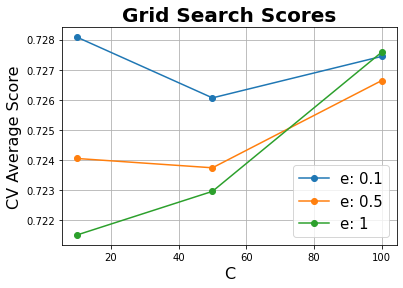

In [46]:
%%time

cc = [ 10, 50, 100 ]
gg = [ 1e-5, 1e-6]
ee = [0.1,  0.5, 1]
dd = [2, 3, 4]
tuned_parameters = [ {
    'C': cc,
    #'gamma': gg,
    #'degree': dd
    'epsilon': ee
} ]

svr = GridSearchCV(SVR(
    #epsilon = 0.5, 
    gamma = 1e-5,
    kernel = 'poly', 
    degree = 3
), tuned_parameters, cv = 5, n_jobs = -1 )
svr.fit(train_t, train_l)

print(svr.best_params_)

plot_grid_search(svr.cv_results_, cc, ee, 'C', 'e')

## Validation

With the test set, we do a validation of the prediction to test for e.g. overfitting. 

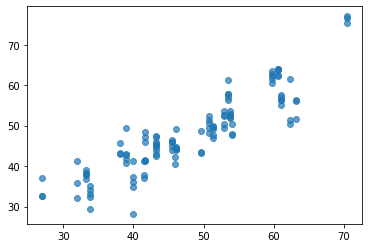

werkelijk gewicht:5.45, voorspeld gewicht: 5.48, perc: 1.0, r2: 0.81


In [47]:
clf = SVR(kernel='poly', degree=3, gamma = 1e-5, C = 50, epsilon = 0.5 )
clf.fit(train_t, train_l)

s= round(clf.score(test_t, test_l),2)
y = clf.predict(test_t)
    
plt.scatter(test_l, y, alpha = 0.7)
plt.show()
    
print( 
    "werkelijk gewicht:" + str( round( sum(test_l)/1000 , 2 ) ) +
    ", voorspeld gewicht: " + str( round( sum(y)/1000, 2 ) ) +
    ", perc: " + str( round ( sum(y) / sum(test_l) ,2 ) ) +
    ", r2: " + str( s )
    )


# Predict

## Final model

In [50]:
k = 'poly'
d = 3
g = 1e-5
c = 50
e = 0.5

data = pd.merge(roosgewicht,aweta_data,on=['lot_id','sessie'],how='left')

train_t = data.drop(['sessie', 'lot_id', 'machine', 'gr'], axis=1)
train_l = data.gr

clf = SVR(kernel=k, degree=d, gamma = g, C = c, epsilon = e )
clf.fit(train_t, train_l)

SVR(C=50, epsilon=0.5, gamma=1e-05, kernel='poly')

## Data

From the xml files, collected from the Aweta harvest machine, parametes are extracted. These parameters are used for the prediction.

In [51]:
file_path = "D:\P_17 - roosgewicht\data\harvest.jsonl"
json = pd.read_json(path_or_buf=file_path, lines=True)
json[1:5]

,avg,max,min,stddev,sum,parameter_id,endtime,id,packageid,starttime,...,lot_id,lot_number,__LOT_NR,__PRODUCTGROUP_ID,__PRODUCTGROUP_NAME,__SUPPLIER_NAME,classification_nr,classification_products_pieces,Class,__CLASS_NAME
1,417,417,417,0,417,114,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,...,4080,210411-4864,210411-4864,4510,Red Naomi! Prime,<geen>,4,1,7,A1 L40 dun br2_b
2,73,73,73,0,73,117,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,...,4080,210411-4864,210411-4864,4510,Red Naomi! Prime,<geen>,4,1,7,A1 L40 dun br2_b
3,79,79,79,0,79,118,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,...,4080,210411-4864,210411-4864,4510,Red Naomi! Prime,<geen>,4,1,7,A1 L40 dun br2_b
4,600,600,600,0,600,140,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,...,4080,210411-4864,210411-4864,4510,Red Naomi! Prime,<geen>,4,1,7,A1 L40 dun br2_b


In [52]:
df = json[['id','classification_nr', 'classification_products_pieces','avg', 'parameter_id']]
df = df[df.parameter_id.isin(['4', '140', '141', '114', '113'])]
df.classification_products_pieces = pd.to_numeric( df.classification_products_pieces )

# 
df = pd.pivot_table(df, values='avg', index=['id', 'classification_nr', 'classification_products_pieces'],
                columns=['parameter_id'])

df = df.reset_index(drop=False)
df = df.rename_axis(None, axis=1)

df[1:5]

,id,classification_nr,classification_products_pieces,113,114,140,141
1,00008f5a-9b6f-11eb-8000-00606532ca1c,8,1,393,339,400,54
2,00008f5a-9b6f-11eb-8000-00606532ca1c,11,1,494,435,397,49
3,00008f5a-9b6f-11eb-8000-00606532ca1c,18,2,452,439,400,69
4,00008f5a-9b6f-11eb-8000-00606532ca1c,29,1,429,313,463,43


##  Predict

In [53]:
df_predict = df
y = clf.predict(df[[113, 114, 140, 141]])

df_predict['gr'] = y 
df_predict.gr = df_predict.gr.round()
df_predict[1:5]

,id,classification_nr,classification_products_pieces,113,114,140,141,gr
1,00008f5a-9b6f-11eb-8000-00606532ca1c,8,1,393,339,400,54,24.0
2,00008f5a-9b6f-11eb-8000-00606532ca1c,11,1,494,435,397,49,27.0
3,00008f5a-9b6f-11eb-8000-00606532ca1c,18,2,452,439,400,69,32.0
4,00008f5a-9b6f-11eb-8000-00606532ca1c,29,1,429,313,463,43,24.0


In [55]:
out = df_predict[['id', "classification_nr", "gr", "classification_products_pieces"]].melt(
    id_vars=['id', "classification_nr", "classification_products_pieces"], 
    var_name="parameter_id", 
    value_name="avg")

out['sum'] = out.avg * out.classification_products_pieces

out.loc[(out.parameter_id == 'gr'),'parameter_id']=99
out[ 'min'], out[ 'max'] = out[ 'avg'], out[ 'avg']
out[ 'stddev'] = 0



out[1:5]

#out.dtypes

,id,classification_nr,classification_products_pieces,parameter_id,avg,sum,min,max,stddev
1,00008f5a-9b6f-11eb-8000-00606532ca1c,8,1,99,24.0,24.0,24.0,24.0,0
2,00008f5a-9b6f-11eb-8000-00606532ca1c,11,1,99,27.0,27.0,27.0,27.0,0
3,00008f5a-9b6f-11eb-8000-00606532ca1c,18,2,99,32.0,64.0,32.0,32.0,0
4,00008f5a-9b6f-11eb-8000-00606532ca1c,29,1,99,24.0,24.0,24.0,24.0,0


In [27]:
print( "Aantal rozen in voorspelling: " + str( round(sum( out.classification_products_pieces ) ) ) + "st" )
print( "Voorspelde : " +  str( round(sum( out['sum'] )/1000 ) )  + "kg")
random.seed(15)

print( "Validatie, random sample van " + 
      str( round(sum( out.classification_products_pieces ) ) ) + 
      " rozen uit de train data: " +
      str( 
          round(
              sum(
                  data.iloc[ sample( [i for i in range(len(data))], 552)].gr)/1000)) +
      " kg"
     )

Aantal rozen in voorspelling: 552st
Voorspelde : 25kg
Validatie, random sample van 552 rozen uit de train data: 25 kg


# output

In [56]:
json_out = json.drop(['parameter_id', 'avg', 'sum', 'min', 'max', 'stddev'], axis=1).drop_duplicates()


json_out = pd.merge(
    json_out,
    out.drop(['classification_products_pieces'], axis=1),
    on=['id', 'classification_nr'],how='left')


json_out

sum(json_out['sum'])

24784.0

In [57]:
json_out

,endtime,id,packageid,starttime,type,GRADERID,hangposition,STATIONNUMBER,RUNTIME,STOPTIME,...,classification_nr,classification_products_pieces,Class,__CLASS_NAME,parameter_id,avg,sum,min,max,stddev
0,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,normal,3,0,0,00:15:06,00:00:01,...,4,1,7,A1 L40 dun br2_b,99,26.0,26.0,26.0,26.0,0
1,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,normal,3,0,0,00:15:06,00:00:01,...,8,1,7,A1 L40 normaal br1_a,99,24.0,24.0,24.0,24.0,0
2,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,normal,3,0,0,00:15:06,00:00:01,...,11,1,7,A1 L40 normaal br2_b,99,27.0,27.0,27.0,27.0,0
3,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,normal,3,0,0,00:15:06,00:00:01,...,18,2,7,A1 L40 dik br2_b,99,32.0,64.0,32.0,32.0,0
4,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,normal,3,0,0,00:15:06,00:00:01,...,29,1,6,A1 L50 dun br1_a,99,24.0,24.0,24.0,24.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,normal,3,0,0,00:15:06,00:00:01,...,401,2,17,Rauw 50,99,34.0,68.0,34.0,34.0,0
162,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,normal,3,0,0,00:15:06,00:00:01,...,402,3,17,Rauw 55,99,42.0,126.0,42.0,42.0,0
163,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,normal,3,0,0,00:15:06,00:00:01,...,403,12,16,Rauw 60,99,45.0,540.0,45.0,45.0,0
164,2021-04-12T09:26:07Z,00008f5a-9b6f-11eb-8000-00606532ca1c,1,2021-04-12T09:11:00Z,normal,3,0,0,00:15:06,00:00:01,...,404,6,15,Rauw 70,99,45.0,270.0,45.0,45.0,0
